In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn flask pyngrok

First 5 rows of the dataset:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450

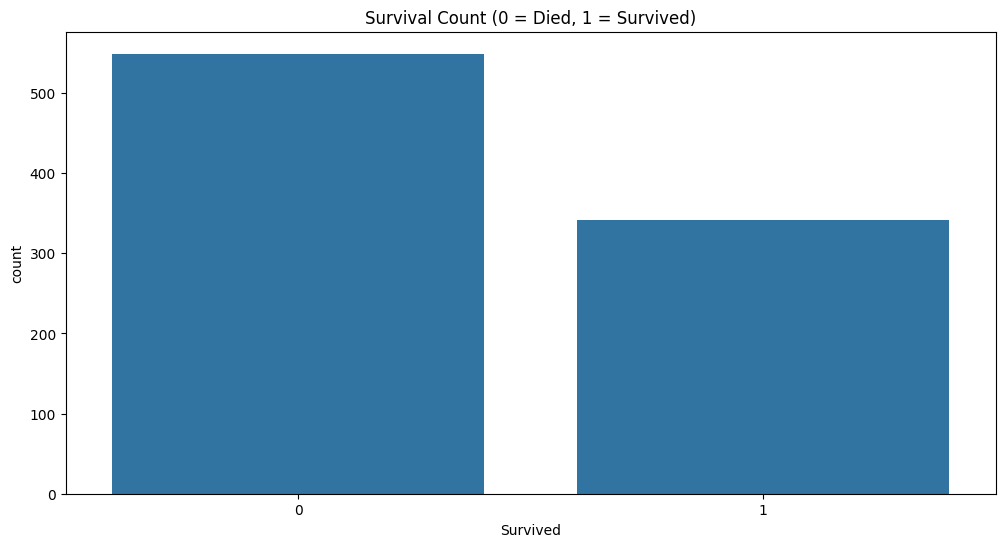

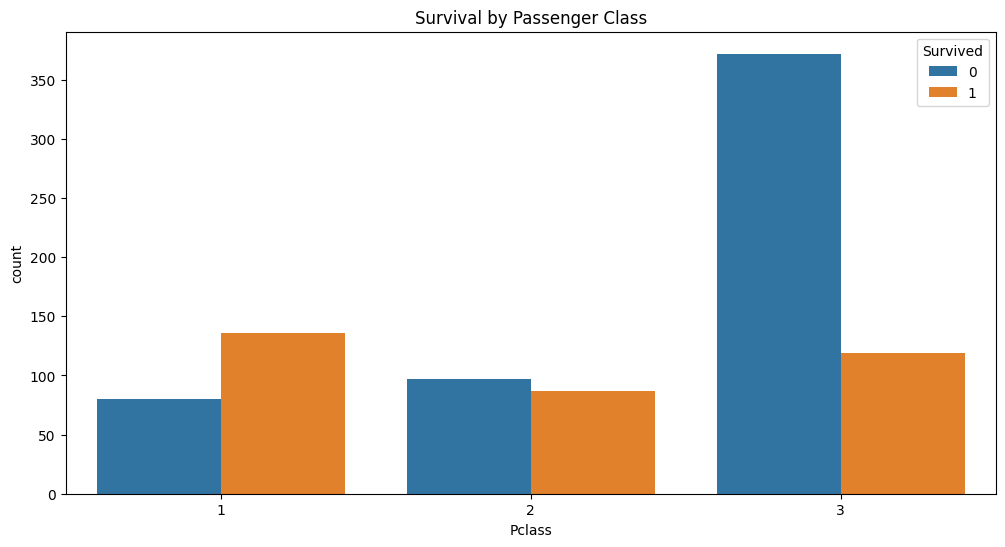

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pickle

# Load the dataset
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
data = pd.read_csv(url)

# Display first few rows
print("First 5 rows of the dataset:")
print(data.head())

# Basic info
print("\nDataset info:")
print(data.info())

# Statistical summary
print("\nStatistical summary:")
print(data.describe())

# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())

# Visualizations
plt.figure(figsize=(12, 6))
sns.countplot(x='Survived', data=data)
plt.title('Survival Count (0 = Died, 1 = Survived)')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='Pclass', hue='Survived', data=data)
plt.title('Survival by Passenger Class')
plt.show()

In [3]:
# Handle missing values
data['Age'].fillna(data['Age'].median(), inplace=True)
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
data.drop('Cabin', axis=1, inplace=True)  # Too many missing values

# Feature engineering
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
data['IsAlone'] = 0
data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1

# Convert categorical variables
label_encoder = LabelEncoder()
data['Sex'] = label_encoder.fit_transform(data['Sex'])
data['Embarked'] = label_encoder.fit_transform(data['Embarked'])

# Select features and target
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'IsAlone']
X = data[features]
y = data['Survived']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train[['Age', 'Fare']] = scaler.fit_transform(X_train[['Age', 'Fare']])
X_test[['Age', 'Fare']] = scaler.transform(X_test[['Age', 'Fare']])

<ipython-input-3-0f89c64b0d06>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(data['Age'].median(), inplace=True)
<ipython-input-3-0f89c64b0d06>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

Accuracy: 0.8156424581005587

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       105
           1       0.79      0.76      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.81      0.82      0.82       179



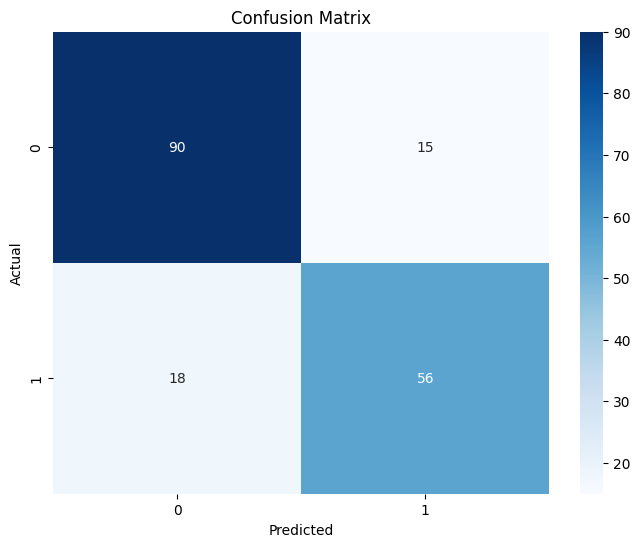

In [4]:
# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the model and preprocessing objects
with open('titanic_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [5]:
%%writefile app.py
from flask import Flask, request, jsonify, render_template
import pickle
import numpy as np

app = Flask(__name__)

# Load the model and preprocessing objects
with open('titanic_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get data from form
        data = request.form.to_dict()

        # Convert to proper types
        pclass = int(data['pclass'])
        sex = data['sex']
        age = float(data['age'])
        sibsp = int(data['sibsp'])
        parch = int(data['parch'])
        fare = float(data['fare'])
        embarked = data['embarked']

        # Preprocess
        sex_encoded = label_encoder.transform([sex])[0]
        embarked_encoded = label_encoder.transform([embarked])[0]

        # Calculate derived features
        family_size = sibsp + parch + 1
        is_alone = 1 if family_size == 1 else 0

        # Scale numerical features
        age_fare_scaled = scaler.transform([[age, fare]])
        age_scaled = age_fare_scaled[0][0]
        fare_scaled = age_fare_scaled[0][1]

        # Create feature array
        features = [pclass, sex_encoded, age_scaled, sibsp, parch, fare_scaled,
                   embarked_encoded, family_size, is_alone]

        # Make prediction
        prediction = model.predict([features])
        probability = model.predict_proba([features])[0][1]

        # Return result
        result = {
            'prediction': int(prediction[0]),
            'probability': float(probability),
            'message': 'Survived' if prediction[0] == 1 else 'Did not survive'
        }

        return render_template('index.html', prediction_text=f"Prediction: {result['message']} (Probability: {result['probability']:.2f})")

    except Exception as e:
        return jsonify({'error': str(e)}), 400

if __name__ == '__main__':
    app.run(debug=True)

Writing app.py


In [6]:
!mkdir -p templates

In [7]:
%%writefile templates/index.html
<!DOCTYPE html>
<html>
<head>
    <title>Titanic Survival Predictor</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            max-width: 600px;
            margin: 0 auto;
            padding: 20px;
        }
        .form-group {
            margin-bottom: 15px;
        }
        label {
            display: block;
            margin-bottom: 5px;
        }
        input, select {
            width: 100%;
            padding: 8px;
            box-sizing: border-box;
        }
        button {
            background-color: #4CAF50;
            color: white;
            padding: 10px 15px;
            border: none;
            cursor: pointer;
        }
        button:hover {
            background-color: #45a049;
        }
        .prediction {
            margin-top: 20px;
            padding: 10px;
            background-color: #f8f9fa;
            border-radius: 5px;
        }
    </style>
</head>
<body>
    <h1>Titanic Survival Predictor</h1>
    <form action="/predict" method="post">
        <div class="form-group">
            <label for="pclass">Passenger Class (1, 2, or 3):</label>
            <input type="number" id="pclass" name="pclass" min="1" max="3" required>
        </div>

        <div class="form-group">
            <label for="sex">Sex:</label>
            <select id="sex" name="sex" required>
                <option value="male">Male</option>
                <option value="female">Female</option>
            </select>
        </div>

        <div class="form-group">
            <label for="age">Age:</label>
            <input type="number" id="age" name="age" min="0" max="100" step="0.1" required>
        </div>

        <div class="form-group">
            <label for="sibsp">Number of Siblings/Spouses Aboard:</label>
            <input type="number" id="sibsp" name="sibsp" min="0" max="10" required>
        </div>

        <div class="form-group">
            <label for="parch">Number of Parents/Children Aboard:</label>
            <input type="number" id="parch" name="parch" min="0" max="10" required>
        </div>

        <div class="form-group">
            <label for="fare">Fare:</label>
            <input type="number" id="fare" name="fare" min="0" step="0.01" required>
        </div>

        <div class="form-group">
            <label for="embarked">Port of Embarkation:</label>
            <select id="embarked" name="embarked" required>
                <option value="C">Cherbourg</option>
                <option value="Q">Queenstown</option>
                <option value="S">Southampton</option>
            </select>
        </div>

        <button type="submit">Predict Survival</button>
    </form>

    {% if prediction_text %}
    <div class="prediction">
        <h3>Result:</h3>
        <p>{{ prediction_text }}</p>
    </div>
    {% endif %}
</body>
</html>

Writing templates/index.html


In [9]:
!pip install flask pyngrok

In [10]:
from flask import Flask

# Create the Flask app
app = Flask(__name__)

@app.route('/')
def home():
    return "Hello from Google Colab!"

# Optional: Add more routes
@app.route('/test')
def test():
    return "This is a test route!"

In [11]:
import threading

# Run Flask in a thread to avoid blocking Colab
thread = threading.Thread(target=app.run, kwargs={'host': '0.0.0.0', 'port': 5000, 'use_reloader': False})
thread.start()